In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

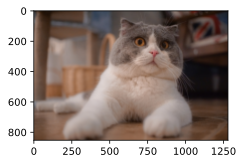

In [3]:
d2l.set_figsize()
img = d2l.Image.open('../data/cat.jpg')
d2l.plt.imshow(img) 

In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows*num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

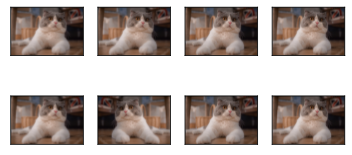

In [5]:
# 水平方向随机翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

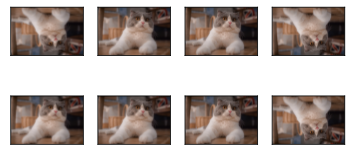

In [6]:
# 上下随机翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

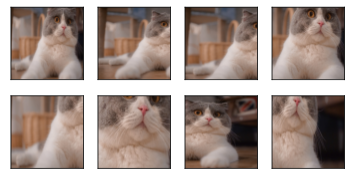

In [7]:
# 随机裁剪 然后缩放到600X600 ratio是高宽比 scale是裁剪的图片占原图片的比例
shape_aug = torchvision.transforms.RandomResizedCrop(
    (600,600), scale=(0.1,1), ratio=(0.5,2))
apply(img,shape_aug)

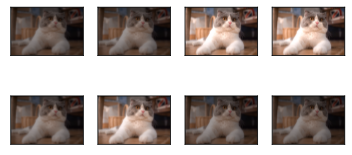

In [8]:
# 随机改变图像的亮度
# saturation 饱和度
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

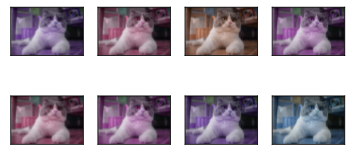

In [9]:
# 随机改变图像的色调
# saturation 饱和度
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

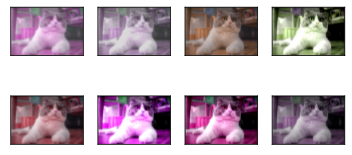

In [10]:
# 随机改变图像的亮度 对比度 饱和度 色调
# saturation 饱和度
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)

apply(img, color_aug)

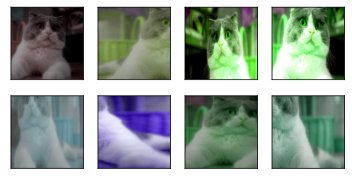

In [11]:
# 结合多种图像增广方法
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    shape_aug, color_aug])
apply(img, augs)

Files already downloaded and verified


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

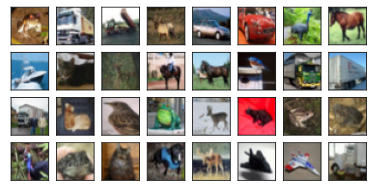

In [13]:
all_images = torchvision.datasets.CIFAR10(
    train=True, root="../data",download=True)
d2l.show_images([
    all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [15]:
# ToTensor转为4D的张量 便于之后训练数据
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])
test_augs = torchvision.transforms.Compose([ 
    torchvision.transforms.ToTensor()])

In [16]:
# 数据的增广是在数据读入内存时进行的 不会在硬盘上存储
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root='../data', train=is_train,
        transform=augs, download=True)
    dataload = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,
        num_workers=d2l.get_dataloader_workers())
    return dataload

In [20]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    # 把数据迁移到指定设备上
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    # 开启训练模式
    net.train()
    # 梯度置零
    trainer.zero_grad()
    # 前向传播
    pred = net(X)
    # 计算损失
    l = loss(pred,y)
    # 计算梯度 反向传播
    l.sum().backward()
    # 梯度下降 计算一次
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer,
               num_epochs, devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度 训练损失 训练准确度 实例数 特点数
        metric = d2l.Accumulator(4)
        for i,(features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i+1)%(num_batches //5)==0 or i == num_batches-1:
                animator.add(epoch+(i+1)/num_batches,
                             (metric[0] / metric[2], 
                              metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [21]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10,3)

def init_weight(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weight)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

KeyboardInterrupt: 

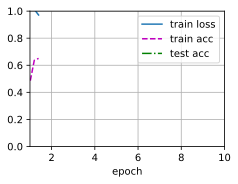

In [22]:
# 使用数据增广
train_with_data_aug(train_augs, test_augs, net)

In [ ]:
# 不适用数据增广
train_with_data_aug(test_augs, test_augs, net)